# Лабораторная работа №5

## Сети с обратными связями

Выполнил Попов Матвей

Группа М8О-408Б-20

Вариант 21

### Цель работы

Исследование свойств сетей Хопфилда, Хэмминга и Элмана, алгоритмов обучения, а
также применение сетей в задачах распознавания статических и динамических
образов.


### Сценарий работы

Использовать сеть Элмана для распознавания динамических образов. Проверить
качество распознавания.


Импортируем необходимые библиотеки

In [9]:
import numpy as np

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

Зададим входные данные

In [10]:
def fp1(k):
    return np.sin(4 * np.pi * k)

def g(k):
    return np.sin(np.sin(k) * k**2 - k)

k1 = [0, 1]

k2 = [1.12, 3.6]

h = 0.025

r = (3, 0, 5)

Визуализируем два сигнала

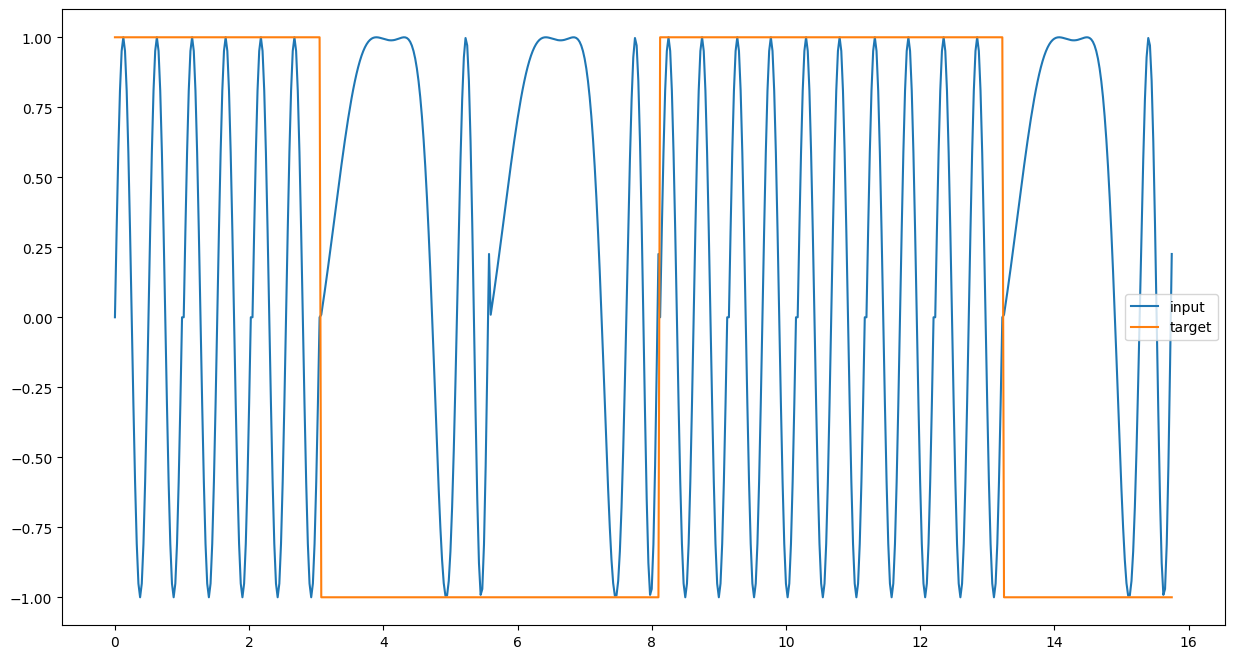

In [11]:
k1 = np.arange(k1[0], k1[1] + h, h)
k2 = np.arange(k2[0], k2[1] + h, h)

p1 = fp1(k1)
p2 = g(k2)

p = np.concatenate((
    np.tile(p1, r[0]), p2,
    np.tile(p1, r[1]), p2,
    np.tile(p1, r[2]), p2,
))

t = np.concatenate((
    np.ones(len(p1) * r[0]), -np.ones(len(p2)),
    np.ones(len(p1) * r[1]), -np.ones(len(p2)),
    np.ones(len(p1) * r[2]), -np.ones(len(p2)),
))

x = np.arange(len(p)) * h

plt.figure(figsize=(15, 8))

plt.plot(x, p, label='input')
plt.plot(x, t, label='target')
plt.legend()

plt.show()

Подготовим датасет

In [12]:
delay = 5

p_train = np.array([np.hstack([p[i:i+delay]]) for i in range(len(p) - delay)])
t_train = np.array([np.hstack([t[i:i+delay]]) for i in range(len(t) - delay)])

Реализуем сеть Элмана

In [13]:
class Elman(keras.layers.Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        self.prev = tf.Variable(tf.zeros((1, output_dim)))
        super(Elman, self).__init__(**kwargs)

    def build(self, input_shape):
        self.w1 = self.add_weight(
            name='w1',
            shape=(input_shape[1], self.output_dim),
            initializer='uniform',
            trainable=True,
        )

        self.w2 = self.add_weight(
            name='w2',
            shape=(self.output_dim, self.output_dim),
            initializer='uniform',
            trainable=True,
        )

        self.b = self.add_weight(
            name='b',
            shape=(self.output_dim, self.output_dim),
            initializer='uniform',
            trainable=True,
        )

        super(Elman, self).build(input_shape)

    def call(self, inputs):
        res = inputs @ self.w1 + self.b
        res += self.prev @ self.w2
        res = tf.keras.activations.tanh(res)
        self.prev.assign(res)
        return res

Создадим и обучим модель

In [14]:
model = keras.Sequential([
    Elman(output_dim=8),
    keras.layers.Dense(delay),
])

model.compile(
    loss='mse',
    optimizer='Adam',
)

train_info = model.fit(
    p_train,
    t_train,
    batch_size=1,
    epochs=100,
    verbose=0,
)

Проверим модель в действии

<ipython-input-15-105c2c5f970a>:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  preds = np.hstack((


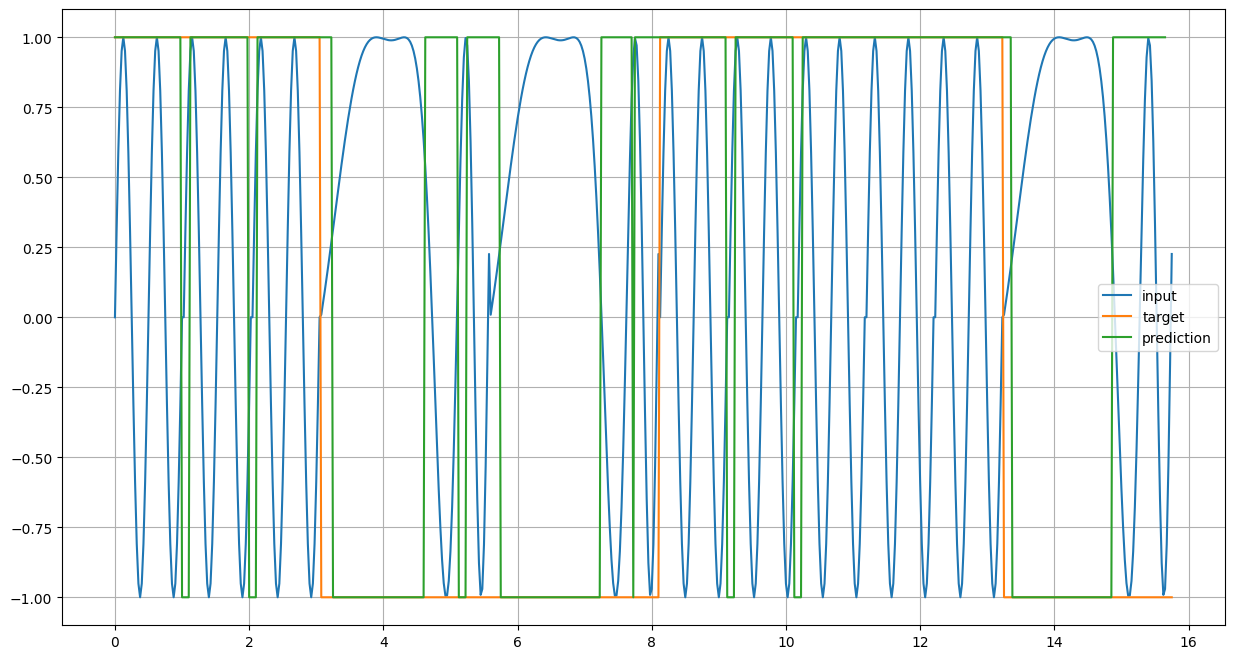

In [15]:
plt.figure(figsize=(15, 8))

preds = np.hstack((
    np.sign(model.predict(
        np.expand_dims(p_train[i], axis=0), verbose=0
    ))
    for i in range(0, len(p_train), delay)
))[0]

plt.plot(x, p, label='input')
plt.plot(x, t, label='target')
plt.plot(x[:-delay+1], preds[:-3], label='prediction')

plt.grid()
plt.legend()
plt.show()

## Вывод

Проделав лабораторную работу, я реализовал слой для сети Элмана и обучил модель
определять тип сигнала.
